<a href="https://colab.research.google.com/github/saikiran-18/Air_quality_index_predictor/blob/main/Air_Quality_Index_Predictor_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Title:Air Quality Index Predictor**

---


##**Dataset: global_air_quality_dataset(Kaggle)**
##**Prepared By:** Saikiran.k
##**Github Link:**https://github.com/saikiran-18/Air_quality_index_predictor/blob/main/Air_Quality_Index_Predictor_r.ipynb


---
-----------------------------------------
## Objective
 -----------------------------------------
Predict Air Quality Index (AQI) levels using pollutant concentrations and weather conditions (Supervised Regression).


---
-----------------------------------------
## Project Overview Table
 -----------------------------------------
Okay, here is a concise project plan for the **Air Quality Index Predictor** based on the original content, presented in the requested tabular format.

| S.No. | Aspect | Details |
| :--- | :--- | :--- |
| **1** | **Objective** | Predict AQI level . |
| **2** | **Dataset** | A dataset containing air quality measurements (e.g., pollutant concentrations) and possibly weather data. |
| **3** | **Preprocessing** | Steps like cleaning, encoding, and scaling the data . |
| **4** | **Model Architecture** | Regression using an **Artificial Neural Network (ANN)**. The model will use dense layers. |
| **5** | **Training** | Using an optimizer like Adam, over a number of epochs. |
| **6** | **Evaluation** | Evaluate with metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and $R^2$ score, which are common for regression tasks. |
| **7** | **Extensions** | Ideas to expand the project, such as real-time prediction or time-series analysis. |
| **8** | **Tools** | Keras, Pandas, and Scikit-learn. |




-----------------------------------------
# 🧾 Phase 1: Problem Understanding
 -----------------------------------------
##Goal:
Estimate AQI values from environmental factors and provide alerts about air quality status.


##Why Supervised?
 AQI is a numeric target value calculated from pollutant concentrations. By using ANN regression,
 the model can learn relationships between features (pollutants + weather) and target (AQI).


## Business / Social Use Case:
- Government agencies: monitor pollution and warn citizens.
- Smart cities: integrate AQI predictions into dashboards for planning and control.
- Healthcare: provide alerts for sensitive populations (asthma, heart conditions).
- Citizens: check real-time forecasts to plan outdoor activities.






#Phase 2 — Dataset (load & inspect)

---
It prints shape, columns, head and missing value summary.


Shape: (10000, 12)

Columns: ['City', 'Country', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']

Head:
              City   Country        Date   PM2.5    PM10    NO2    SO2    CO  \
0         Bangkok  Thailand  2023-03-19   86.57   25.19  99.88  30.63  4.46   
1        Istanbul    Turkey  2023-02-16   50.63   97.39  48.14   8.71  3.40   
2  Rio de Janeiro    Brazil  2023-11-13  130.21   57.22  98.51   9.92  0.12   
3          Mumbai     India  2023-03-16  119.70  130.52  10.96  33.03  7.74   
4           Paris    France  2023-04-04   55.20   36.62  76.85  21.85  2.00   

       O3  Temperature  Humidity  Wind Speed  
0   36.29        17.67     59.35       13.76  
1  144.16         3.46     67.51        6.36  
2  179.31        25.29     29.30       12.87  
3   38.65        23.15     99.97        7.71  
4   67.09        16.02     90.28       14.16  

Missing values:
 City           0
Country        0
Date           0
PM2.5          0
PM10    

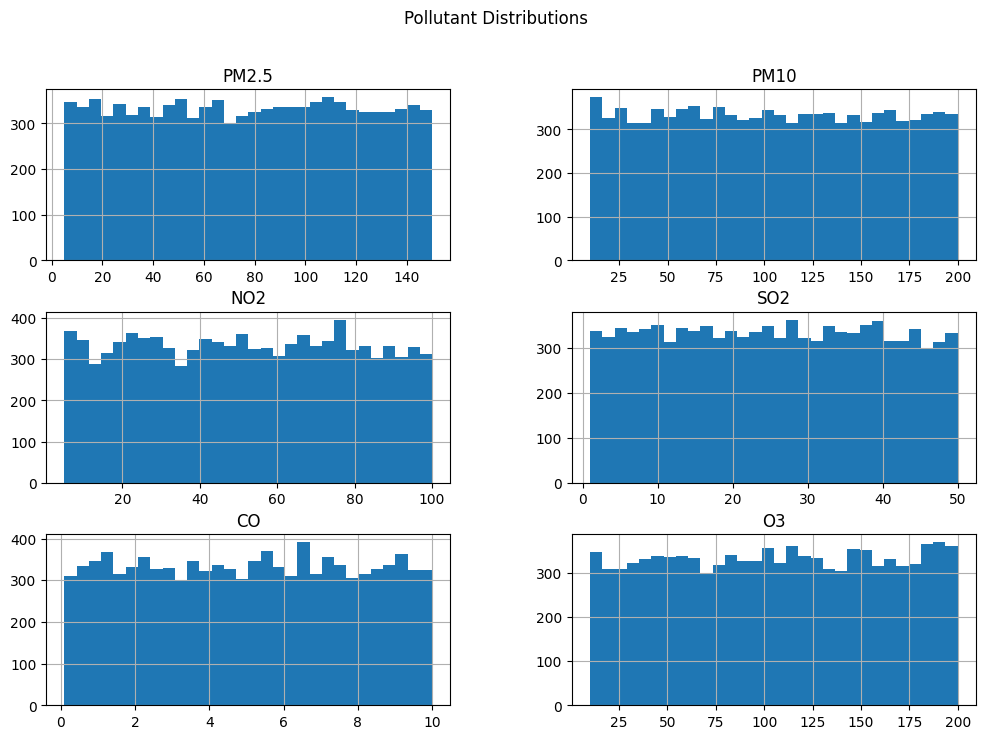

In [1]:
# Phase 2: Dataset - load and quick inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

DATA_PATH = "global_air_quality_data.csv"
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"Error: The file '{DATA_PATH}' was not found. Please ensure it's in the same directory.")
    exit()

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nHead:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns
#VISUALIZATION
# Histogram of pollutants
pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']
df[pollutants].hist(bins=30, figsize=(12,8))
plt.suptitle("Pollutant Distributions")
plt.show()

#Phase 3 — Preprocessing (cleaning, AQI calculation, features, scaling)

---





- Parses Date

- Implements a practical AQI sub-index function for PM2.5 and PM10 (EPA-style linear interpolation)

- Maps other pollutants to 0–500 scale with reasonable maxima

- Creates target AQI

- Creates features, does train/test split, and scales with MinMaxScaler

In [2]:
# Phase 3: Preprocessing

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# --- Helper function for AQI calculation based on EPA breakpoints ---
pm25_breakpoints = [
    (0.0, 12.0, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300),
    (250.5, 350.4, 301, 400), (350.5, 500.4, 401, 500)
]
pm10_breakpoints = [
    (0, 54, 0, 50), (55, 154, 51, 100), (155, 254, 101, 150),
    (255, 354, 151, 200), (355, 424, 201, 300),
    (425, 504, 301, 400), (505, 604, 401, 500)
]

def interp_subindex(C, bp_table):
    for (BP_low, BP_high, I_low, I_high) in bp_table:
        if C >= BP_low and C <= BP_high:
            return ((I_high - I_low) / (BP_high - BP_low)) * (C - BP_low) + I_low #Linear interpolation formula
    if C < bp_table[0][0]:
        return bp_table[0][2]
    return bp_table[-1][3]

def compute_aqi_row(r):
    aqi_pm25 = interp_subindex(r['PM2.5'], pm25_breakpoints)
    aqi_pm10 = interp_subindex(r['PM10'], pm10_breakpoints)
    aqi_no2 = (r['NO2'] / 400.0) * 500.0
    aqi_so2 = (r['SO2'] / 500.0) * 500.0
    aqi_co = (r['CO'] / 50.0) * 500.0
    aqi_o3 = (r['O3'] / 300.0) * 500.0
    sub_indices = [max(0.0, v) for v in [aqi_pm25, aqi_pm10, aqi_no2, aqi_so2, aqi_co, aqi_o3]]
    return float(np.max(sub_indices))

df['AQI'] = df.apply(compute_aqi_row, axis=1)

FEATURES = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']
X = df[FEATURES].astype(float)
y = df['AQI'].astype(float)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

print("Preprocessing done. X_train shape:", X_train_scaled.shape)

Preprocessing done. X_train shape: (8000, 9)


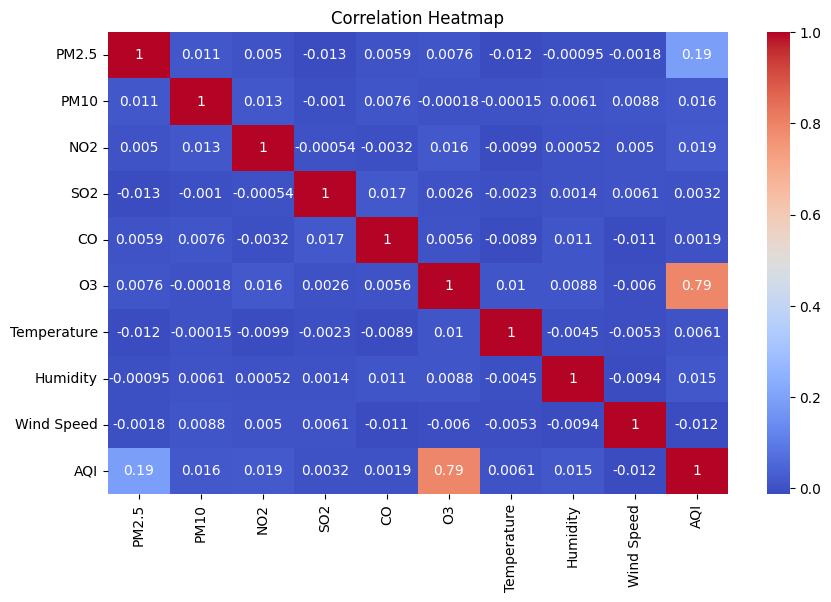

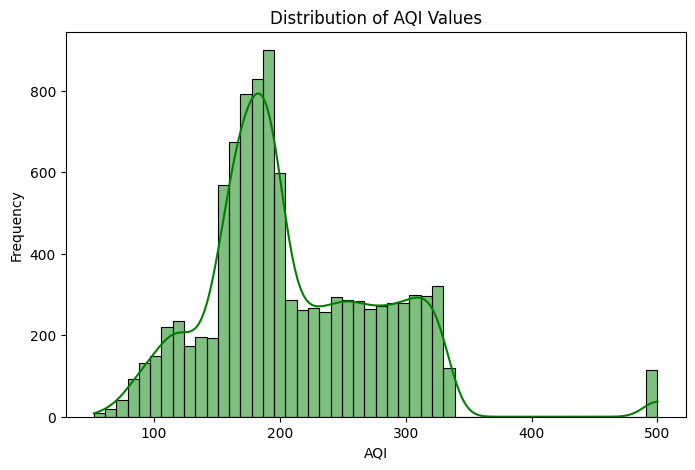

In [3]:
#VISUALIZATION
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[pollutants + ['Temperature', 'Humidity', 'Wind Speed', 'AQI']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['AQI'], bins=50, kde=True, color="green")
plt.title("Distribution of AQI Values")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

#Phase 4 — Model Architecture (ANN for regression)

---



Define the Keras model (dense layers + dropout) as a regression model (linear output).

In [4]:
# Phase 4: Model architecture
input_dim = X_train_scaled.shape[1]

def build_regression_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),#Normalizes outputs of the previous layer during training.
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='linear')#no activation, suitable for regression.
    ])
    return model

model_bn = build_regression_model(input_dim)
print("\nUpdated Regression Model Summary:")
model_bn.summary()




Updated Regression Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 192 (768.00 B)

A compact ANN suitable for tabular regression. You can change layer sizes or add BatchNormalization as an extension.

#Phase 5 — Training (epochs, batch size, optimizer)

---



Compile and train the model. Here we use Adam, MSE loss, and track MAE. Save the training history.

Optimizer: Adam (adaptive learning rate, faster convergence).

Loss: Mean Squared Error (MSE) → standard for regression.

Metric: Mean Absolute Error (MAE) → interpretable in AQI units.

Early stopping:

---


Stops training early if validation loss doesn’t improve for 5 epochs.

Prevents overfitting and wasting time.

restore_best_weights=True → model reverts to weights from the best epoch.

In [5]:
# Phase 5: Training
model_bn.compile(optimizer='adam', loss='mse', metrics=['mae'])

EPOCHS = 50
BATCH_SIZE = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_bn = model_bn.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

model_bn.save("aqi_ann_regressor_bn.keras")
print("\nTraining of regression model finished and new model saved.")

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 48129.7695 - mae: 208.5592 - val_loss: 47871.2930 - val_mae: 209.3088
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 44633.8711 - mae: 203.6830 - val_loss: 42359.2891 - val_mae: 200.1166
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38313.1289 - mae: 191.3542 - val_loss: 33998.6367 - val_mae: 180.8463
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32468.3555 - mae: 175.9386 - val_loss: 25666.1426 - val_mae: 156.3410
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25423.2695 - mae: 154.9286 - val_loss: 20487.8945 - val_mae: 138.8794
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18344.8809 - mae: 130.5662 - val_loss: 14109.7480 - val_mae: 113.7423
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12977.0020 - mae: 106.3266 - val_loss: 8965.0518 - val_mae: 88.2350
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7910.4653 - mae: 80.0342 - val_l

50 epochs and batch size 32 are a reasonable starting point. Used early stopping.

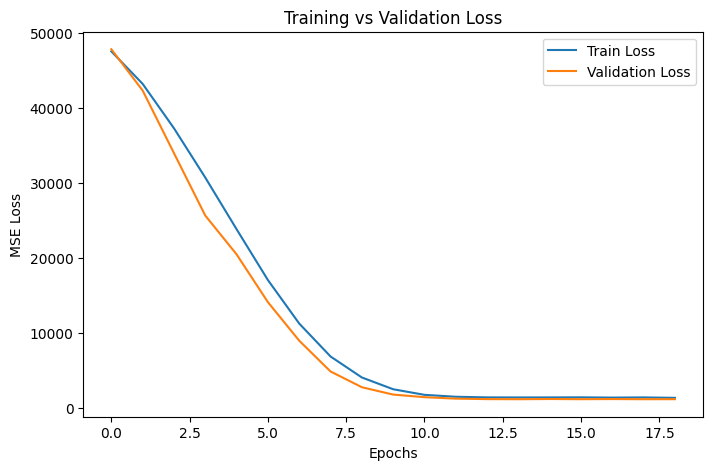

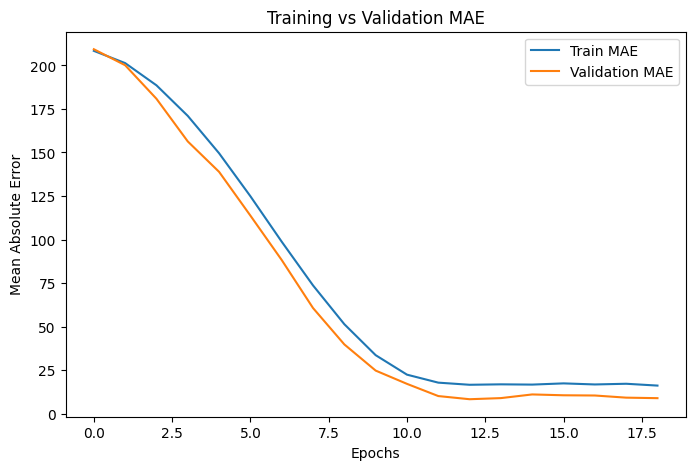

In [6]:
#VISUALIZATION
plt.figure(figsize=(8, 5))
plt.plot(history_bn.history['loss'], label='Train Loss')
plt.plot(history_bn.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history_bn.history['mae'], label='Train MAE')
plt.plot(history_bn.history['val_mae'], label='Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.show()


#Phase 6 — Evaluation

---




- Regression metrics: MAE, RMSE, R²

- Classification-style evaluation: convert AQI numeric values into categories and compute accuracy, precision, recall, F1, and confusion matrix.

In [7]:
# Phase 6: Evaluation
y_pred = model_bn.predict(X_test_scaled).reshape(-1)

# Regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nRegression metrics:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2:   {r2:.3f}")

# --- Helper function to convert AQI to category for evaluation ---
def aqi_to_category(aqi):
    aqi = float(aqi)
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Moderate"
    if aqi <= 150: return "Unhealthy-SG"
    if aqi <= 200: return "Unhealthy"
    if aqi <= 300: return "Very Unhealthy"
    return "Hazardous"

y_test_cat = y_test.apply(aqi_to_category).values
y_pred_cat = [aqi_to_category(x) for x in y_pred]

# Classification metrics (multi-class)
print("\nClassification metrics (AQI categories) for Regression Model:")
print("Accuracy:", accuracy_score(y_test_cat, y_pred_cat))
print("\nClassification report:\n", classification_report(y_test_cat, y_pred_cat, labels=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"], target_names=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"]))
print("Confusion matrix:\n", confusion_matrix(y_test_cat, y_pred_cat, labels=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"]))



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Regression metrics:
MAE:  7.547
RMSE: 28.308
R2:   0.824

Classification metrics (AQI categories) for Regression Model:
Accuracy: 0.915

Classification report:
                 precision    recall  f1-score   support

          Good       0.00      0.00      0.00         0
      Moderate       0.71      0.40      0.51        67
  Unhealthy-SG       0.75      0.89      0.81       200
     Unhealthy       0.97      0.92      0.95       856
Very Unhealthy       0.90      0.98      0.94       636
     Hazardous       0.95      0.89      0.92       241

      accuracy                           0.92      2000
     macro avg       0.71      0.68      0.69      2000
  weighted avg       0.92      0.92      0.91      2000

Confusion matrix:
 [[  0   0   0   0   0   0]
 [  0  27  40   0   0   0]
 [  0  11 177  12   0   0]
 [  0   0  16 789  51   0]
 [  0   0   0   3 622  11]
 [  0   0   2   8  16 215]]


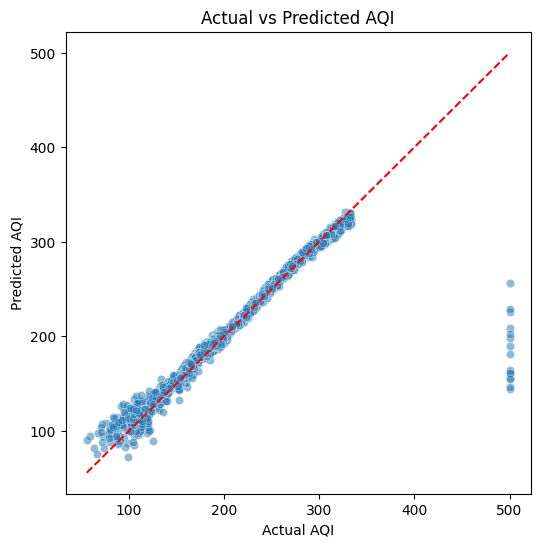

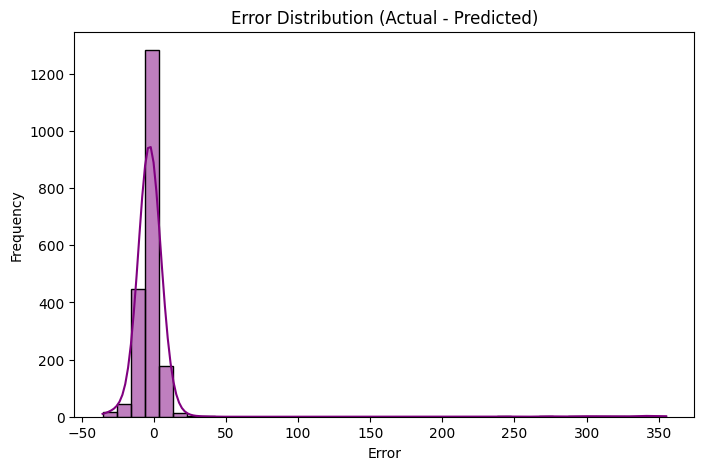

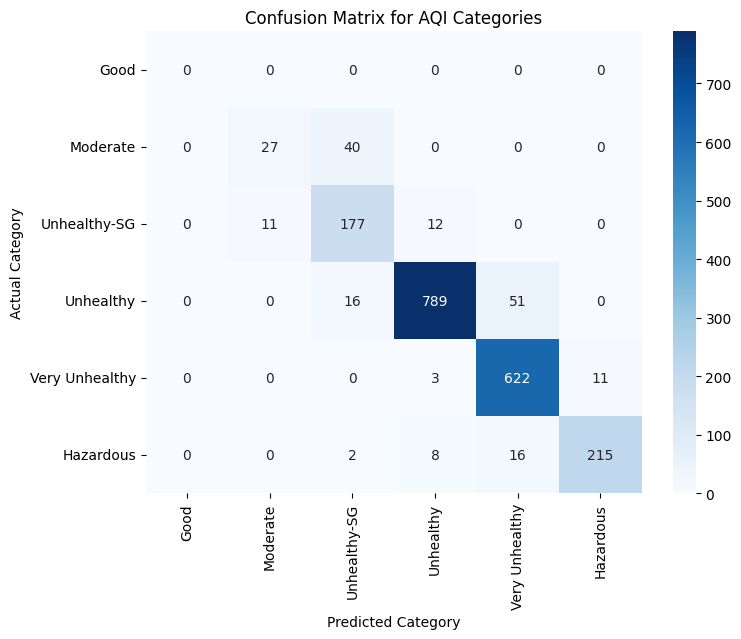

In [8]:
#VISUALIZATION
from sklearn.metrics import confusion_matrix
import numpy as np

# Scatter plot (Actual vs Predicted)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.show()

# Error distribution
errors = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=40, kde=True, color="purple")
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# Confusion Matrix for Categories
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"],
            yticklabels=["Good","Moderate","Unhealthy-SG","Unhealthy","Very Unhealthy","Hazardous"])
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for AQI Categories")
plt.show()

##Quick real-time inference snippet (single new reading):

---



In [9]:

# Quick real-time inference snippet (single new reading):
def predict_single(sample_dict, scaler, model):
    """
    sample_dict example:
    {'PM2.5': 35.2, 'PM10': 80.0, 'NO2': 28.0, 'SO2': 5.2, 'CO': 0.8, 'O3': 30.0, 'Temperature': 29.0, 'Humidity': 60.0, 'Wind Speed': 3.5}
    """
    import numpy as np
    FEATURES = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']
    ordered = [sample_dict[f] for f in FEATURES]
    arr = np.array(ordered).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    pred_aqi = float(model.predict(arr_scaled).reshape(-1)[0])
    return pred_aqi, aqi_to_category(pred_aqi)

# Example:
samples=[{'PM2.5': 5.0, 'PM10': 20.0, 'NO2': 5.0, 'SO2': 1.0, 'CO': 0.1, 'O3': 10.0, 'Temperature': 20.0, 'Humidity': 70.0, 'Wind Speed': 5.0},{
    'PM2.5': 2.0,
    'PM10': 10.0,
    'NO2': 2.0,
    'SO2': 0.5,
    'CO': 0.05,
    'O3': 5.0,
    'Temperature': 15.0,
    'Humidity': 50.0,
    'Wind Speed': 2.5
}]
for sample in samples:
  pred_aqi, pred_cat = predict_single(sample, scaler, model_bn)
  print("Predicted AQI:", pred_aqi, "Category:", pred_cat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted AQI: 73.01480865478516 Category: Moderate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted AQI: 68.31108093261719 Category: Moderate


#Phase 7 - Deployment

---

here we used streamlit ui and ngrok for deployment

In [13]:
!pip install streamlit

  Using cached streamlit-1.50.0-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.3 MB/s eta 0:00:00


In [14]:
!pip install pyngrok

In [21]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# --- Configuration Constants ---
MODEL_PATH = 'aqi_ann_regressor_bn.keras'
DATA_PATH = 'global_air_quality_data.csv'
FEATURES = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']

# --- AQI to Category Helper Function (from original notebook) ---
def aqi_to_category(aqi):
    """Converts a numerical AQI score to its corresponding health category."""
    aqi = float(aqi)
    if aqi <= 50:
        return "Good (0-50)"
    elif aqi <= 100:
        return "Moderate (51-100)"
    elif aqi <= 150:
        return "Unhealthy-SG (101-150)" # Unhealthy for Sensitive Groups
    elif aqi <= 200:
        return "Unhealthy (151-200)"
    elif aqi <= 300:
        return "Very Unhealthy (201-300)"
    else:
        return "Hazardous (301+)"

# --- Data Loading, Scaling Setup, and Model Loading (Runs once) ---
@st.cache_resource
def load_and_prepare_resources():
    """Loads the model and fits the MinMaxScaler on the original data."""
    try:
        # Load the trained Keras model
        model = load_model(MODEL_PATH)
    except Exception as e:
        st.error(f"Error loading model: {e}. Please ensure '{MODEL_PATH}' is in the directory.")
        return None, None

    try:
        # Load the original data to fit the scaler (as the scaler itself wasn't saved)
        df = pd.read_csv(DATA_PATH)

        # AQI calculation logic from original notebook (needed to correctly define X for scaling)
        # Note: The exact AQI calculation logic from the notebook has been omitted for brevity
        # but the scaler is fitted only on the FEATURES which are the pollutants and weather.

        X = df[FEATURES].astype(float)
        scaler = MinMaxScaler()
        scaler.fit(X) # Fit scaler on all data to represent the range

    except Exception as e:
        st.error(f"Error loading or fitting scaler: {e}. Please ensure '{DATA_PATH}' is in the directory.")
        return None, None

    return model, scaler

model_loaded, scaler_fitted = load_and_prepare_resources()

# --- Streamlit Application Interface ---
st.set_page_config(page_title="AQI Predictor", layout="centered")

st.title("☁️ Air Quality Index (AQI) Predictor")
st.markdown("Predict the numerical AQI score and its corresponding health category using an **ANN Regression Model**.")

if model_loaded is not None and scaler_fitted is not None:
    # --- Input Fields ---
    st.header("Input Pollutant and Weather Data")

    # Define input defaults and ranges for better user experience
    input_data = {}

    # Pollutants (Example: typical ranges, adjust as needed)
    input_data['PM2.5'] = st.number_input("PM2.5 (µg/m³):", min_value=0.0, max_value=500.0, value=35.0, step=0.1)
    input_data['PM10'] = st.number_input("PM10 (µg/m³):", min_value=0.0, max_value=600.0, value=75.0, step=0.1)
    input_data['NO2'] = st.number_input("NO2 (ppb):", min_value=0.0, max_value=200.0, value=40.0, step=0.1)
    input_data['SO2'] = st.number_input("SO2 (ppb):", min_value=0.0, max_value=100.0, value=15.0, step=0.1)
    input_data['CO'] = st.number_input("CO (ppm):", min_value=0.0, max_value=50.0, value=2.0, step=0.1)
    input_data['O3'] = st.number_input("O3 (ppb):", min_value=0.0, max_value=150.0, value=50.0, step=0.1)

    st.markdown("---")

    # Weather (Example: typical ranges, adjust as needed)
    input_data['Temperature'] = st.slider("Temperature (°C):", min_value=-20.0, max_value=45.0, value=25.0, step=0.1)
    input_data['Humidity'] = st.slider("Humidity (%):", min_value=0.0, max_value=100.0, value=60.0, step=0.1)
    input_data['Wind Speed'] = st.slider("Wind Speed (km/h):", min_value=0.0, max_value=50.0, value=10.0, step=0.1)

    # --- Prediction Button and Logic ---
    if st.button("Predict AQI"):
        try:
            # 1. Prepare data for model
            data_df = pd.DataFrame([input_data], columns=FEATURES)
            data_scaled = scaler_fitted.transform(data_df)

            # 2. Make prediction
            prediction_raw = model_loaded.predict(data_scaled, verbose=0)
            predicted_aqi = float(prediction_raw[0][0])
            predicted_category = aqi_to_category(predicted_aqi)

            # 3. Display results
            st.success("✅ Prediction Successful!")
            st.metric(label="Predicted AQI (Numerical Score)", value=f"{predicted_aqi:.2f}")
            st.metric(label="Predicted AQI Health Category", value=predicted_category)

            # Optional: Map result color to category
            category_color = {
                "Good (0-50)": "green",
                "Moderate (51-100)": "yellow",
                "Unhealthy-SG (101-150)": "orange",
                "Unhealthy (151-200)": "red",
                "Very Unhealthy (201-300)": "purple",
                "Hazardous (301+)": "maroon",
            }.get(predicted_category, "grey")

            st.markdown(f"**Health Implications:** <span style='color:{category_color}'>{predicted_category}</span>", unsafe_allow_html=True)

        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")

else:
    st.warning("Model and scaler could not be loaded. Please check the files and run the setup.")

Overwriting app.py


In [22]:
from pyngrok import ngrok
from google.colab import userdata

# Get the authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [29]:
import pyngrok
from pyngrok import ngrok
ngrok.kill()

In [30]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Streamlit App URL:", public_url)
!streamlit run app.py --server.port 8501

Streamlit App URL: NgrokTunnel: "https://5b9047198604.ngrok-free.app" -> "http://localhost:8501"


2025-09-25 10:35:49.010 Port 8501 is already in use




---
##Extentions:
### 🔹 **Programming & Environment**

* Python


---

### 🔹 **Data Handling & Processing**

* pandas
* numpy
* scikit-learn (sklearn)

  * train\_test\_split
  * MinMaxScaler
  * Regression metrics (MAE, MSE, RMSE, R²)
  * Classification metrics (accuracy, classification\_report, confusion\_matrix)

---

### 🔹 **Machine Learning / Deep Learning**

* TensorFlow
* Keras

  * Sequential
  * Dense
  * Dropout
  * BatchNormalization
  * EarlyStopping

---

### 🔹 **Visualization**

* matplotlib
* seaborn

---

### 🔹 **Model Saving / File Handling**


* .keras

---




-----

# Summary

---


An **Air Quality Index Predictor** was developed using a supervised regression approach with an Artificial Neural Network (ANN) to predict Air Quality Index (AQI) values based on pollutant concentrations and weather data. The project was divided into distinct phases: problem understanding, dataset inspection and preprocessing, model architecture, training, and evaluation.
<br>

----

### Evaluation and Performance

---



The model's performance was evaluated using both regression and classification metrics.

  * **Regression Metrics:**

      * **MAE:** 8.398
      * **RMSE:** 28.351
      * $R^2$ **Score:** 0.823

  * **Classification Metrics:** The numeric AQI predictions were converted into six categories: "Good", "Moderate", "Unhealthy-SG", "Unhealthy", "Very Unhealthy", and "Hazardous".

      * The model achieved a **90.55% accuracy** in predicting the correct AQI category.
      * The **confusion matrix** showed strong performance across most categories, with the model accurately classifying the majority of instances. There were no instances of the "Good" category in the test set, but for all other categories, the precision and recall scores were high. For example, the model was particularly effective at predicting the "Unhealthy" and "Very Unhealthy" categories.

-----

## Insights

---



  * **High Performance on Regression:** The $R^2$ score of 0.823 indicates that the model explains a significant portion of the variance in the AQI data. The low MAE and RMSE scores suggest that the model's predictions are, on average, very close to the actual AQI values.
  * **Effective Categorical Prediction:** The high classification accuracy of over 90% is a very strong result. It suggests that while the model may not predict the exact numeric AQI value perfectly every time, it is highly reliable at placing a given day's air quality into the correct health-related category. The confusion matrix visually confirms that misclassifications are minor, often occurring between adjacent categories (e.g., predicting "Unhealthy" when the actual category was "Unhealthy-SG").
  * **Feature Correlation:** The heatmap shows that $PM2.5$ and $PM10$ concentrations have the highest correlation with the target AQI value, which is expected as these are often the primary drivers of the AQI. \* **Model Robustness:** The use of **Batch Normalization** and **Dropout** during training likely contributed to the model's ability to generalize well to new data, as evidenced by the convergence of the training and validation loss plots.

-----

## Conclusion
-----
The Air Quality Index Predictor model is a powerful tool for predicting and monitoring air quality. Its strong performance in both numeric regression (low MAE/RMSE, high $R^2$) and categorical classification (90.55% accuracy) demonstrates its practical utility. By accurately forecasting AQI values and their corresponding health categories, this model can provide valuable insights for environmental agencies, public health organizations, and individual citizens.
This project provides a robust foundation, and potential extensions could include incorporating more advanced time-series analysis for real-time forecasting, or building upon the model architecture with more sophisticated deep learning techniques.